In [3]:
# default_exp masking

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
from importlib import reload
from ehv import core
from pathlib import Path
import uuid
import re
import scipy

import pyarrow.parquet as pq

from ehv import load as e_load, core

plt.rcParams['figure.facecolor'] = 'white'

numpy.random.seed(42)

In [8]:
from skimage import img_as_float32

In [9]:
# export
import zarr
from scip.masking import threshold
from scip.masking import util

In [35]:
# export
def plot_scip_segmentation(r, bbox_channel_index=0):
    z = zarr.open(r.meta_path)
    pixels = z[r.meta_zarr_idx].reshape(z.attrs["shape"][r.meta_zarr_idx])
    pixels = numpy.clip(pixels, a_min=0, a_max=4096)

    m = threshold.get_mask(dict(pixels=pixels), main=True, main_channel=bbox_channel_index)
    m = util.get_bounding_box(m, bbox_channel_index=bbox_channel_index)
    m = threshold.get_mask(m, main=False, main_channel=bbox_channel_index)

    fig, axes = plt.subplots(2, len(pixels), dpi=150, squeeze=False)
    for i, (a, p) in enumerate(zip(m["mask"], pixels)):
        axes[0, i].imshow(a)
        axes[0, i].set_axis_off()
        axes[1, i].imshow(p)
        axes[1, i].set_axis_off()
        
    return m

In [179]:
zarr_path, zarr_idx = ('/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Ctrl_T8_R1_25.zarr', 2533)
z = zarr.open(zarr_path)

In [180]:
r = pandas.Series({"meta_path": zarr_path, "meta_zarr_idx": zarr_idx})

In [181]:
pixels = z[zarr_idx].reshape(z.attrs["shape"][zarr_idx])

In [182]:
pixels = numpy.clip(pixels, a_min=0, a_max=4096).astype(float)
pixels = img_as_float32(pixels)

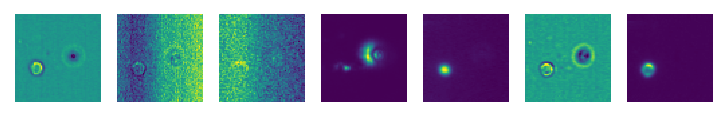

In [183]:
fig, axes = plt.subplots(1, len(pixels), dpi=150, squeeze=False)
axes = axes.ravel()
for p, ax in zip(pixels, axes):
    ax.imshow(p)
    ax.set_axis_off()

In [184]:
from skimage.morphology import closing, remove_small_holes, remove_small_objects, label, disk, binary_closing, binary_dilation
from skimage.filters import sobel, gaussian, threshold_otsu, threshold_mean, threshold_isodata

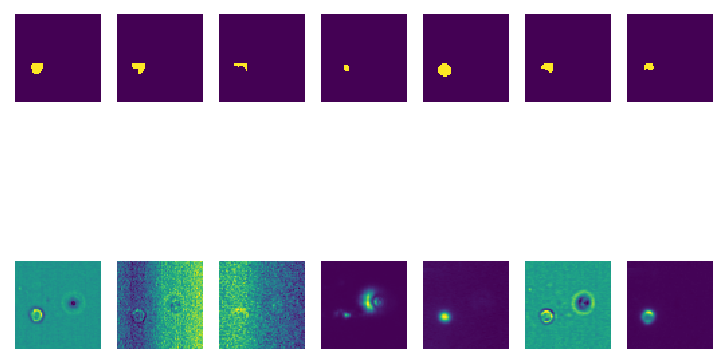

In [185]:
m = plot_scip_segmentation(r, 4)

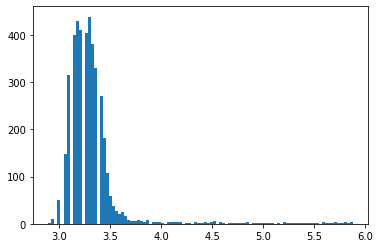

In [190]:
_ = plt.hist(numpy.log(pixels[4].ravel()), bins=100)

In [193]:
t = threshold_otsu(numpy.log(pixels[4]))

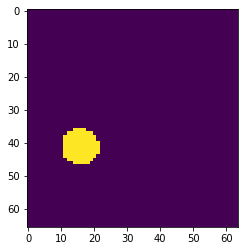

In [194]:
plt.imshow(((numpy.e**t) < pixels[4]))

In [196]:
t = threshold_otsu(pixels[4])

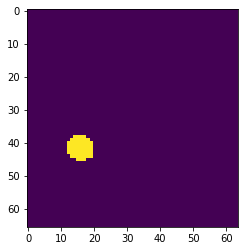

In [197]:
plt.imshow(t < pixels[4])

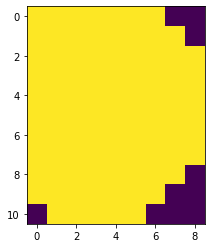

In [158]:
bbox = m["bbox"]
x = pixels[4, bbox[0]:bbox[2], bbox[1]:bbox[3]]

x = gaussian(x, sigma=1)
# x = sobel(x)
# x = closing(x, selem=disk(2))
x = threshold_mean(numpy.log(x)) < numpy.log(x)
x = binary_dilation(x, disk(2))
# x = binary_closing(x, disk(1))
# x = remove_small_holes(x, area_threshold=5)
# x = remove_small_objects(x, min_size=5)
x = label(x)
plt.imshow(x)

In [59]:
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.morphology import white_tophat, disk

In [60]:
pixels2 = pixels.copy()

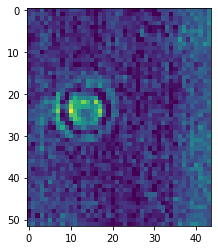

In [61]:
plt.imshow(white_tophat(pixels[1], disk(10)))

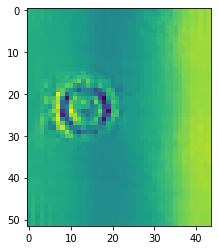

In [82]:
sigma = estimate_sigma(pixels[1])
pixels2[1] = denoise_nl_means(pixels[1], patch_size=10, patch_distance=5, sigma=sigma, h=sigma)
plt.imshow(pixels2[1])

In [83]:
from scip.segmentation import util, threshold

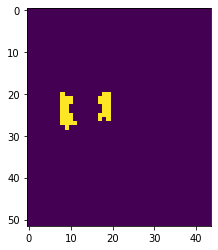

In [84]:
m = threshold.get_mask(dict(pixels=pixels), main=True, main_channel=0)
m = util.get_bounding_box(m, bbox_channel=0)
m = threshold.get_mask(m, main=False, main_channel=0)
plt.imshow(m["mask"][1])

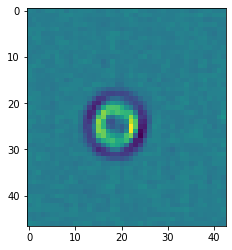

In [52]:
plt.imshow(m["pixels"][0])

# White tophat

In [51]:
from skimage.morphology import white_tophat, disk

In [52]:
bbox = m["bbox"]
bboxed = pixels[:, bbox[0]: bbox[2], bbox[1]:bbox[3]]

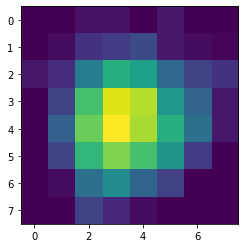

In [54]:
plt.imshow(white_tophat(bboxed[1], selem=disk(3)))

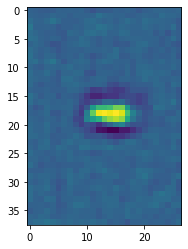

In [24]:
plt.imshow(pixels[0])